This is just a test to check if the algorithm will work.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# Add the root directory of your project to the Python path
project_root = '/Users/aakankschitnandkeolyar/Desktop/PRISMS'
if project_root not in sys.path:
    sys.path.append(project_root)
# Import functionalities from enumeration_utils.py
from PRISMS.library_enumeration.enumeration_utils import find_reactants_from_product_code
# Import functionalities from library_analysis_utils.py
from PRISMS.library_analysis.library_analysis_utils import compile_product_scores, compile_product_smiles

In [3]:
# Import Data from Brute force docking
prod_scores_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores"
prod_scores_df = compile_product_scores(prod_scores_dir)

In [4]:
# Get the top 100 products
top_100_prods = prod_scores_df.sort("Scores", descending=False).head(100)

In [16]:
top_100_prods

Product_Code,Scores
str,f64
"""CA99_AA28_AA61""",-17.828762
"""CA124_AA28_AA61""",-17.288765
"""CA95_AA28_AA61""",-17.248438
"""CA116_AA28_AA61""",-17.240562
"""CA30_AA28_AA61""",-17.236963
…,…
"""CA83_AA32_AA61""",-16.092438
"""CA110_AA6_AA21""",-16.090384
"""CA15_AA22_AA60""",-16.089331


In [5]:
import polars as pl
def polars_compound_comparison(df, compound_col='compound_id'):
    """
    Fully vectorized approach using Polars expressions
    """
    # Create a DataFrame with exploded building blocks
    exploded_df = df.with_row_count('compound_idx').with_columns([
        pl.col(compound_col).str.split('_').alias('blocks')
    ]).explode('blocks')
    
    # Self-join to find compounds sharing building blocks
    shared_blocks_df = exploded_df.join(
        exploded_df, 
        on='blocks', 
        suffix='_other'
    ).filter(
        pl.col('compound_idx') < pl.col('compound_idx_other')
    ).group_by([
        pl.col('compound_idx'),
        pl.col('compound_idx_other'),
        pl.col(compound_col),
        pl.col(f'{compound_col}_other')
    ]).agg([
        pl.col('blocks').unique().alias('shared_blocks')
    ])
    
    return shared_blocks_df.select([
        pl.col(compound_col).alias('compound_1'),
        pl.col(f'{compound_col}_other').alias('compound_2'),
        pl.col('shared_blocks')
    ])


In [6]:
def find_all_shared_building_blocks_polars(df, compound_col='compound_id'):
    """
    Find ALL compound pairs with shared building blocks, including duplicates
    and treating order-reversed compounds as distinct
    """
    # Split compound IDs into building blocks
    df_with_blocks = df.with_columns([
        pl.col(compound_col).str.split('_').alias('building_blocks')
    ])
    
    # Convert to list for easier manipulation
    compounds_data = df_with_blocks.select([
        pl.col(compound_col),
        pl.col('building_blocks')
    ]).to_dicts()
    
    # Compare ALL pairs (including both directions)
    all_shared_pairs = []
    for i, comp1 in enumerate(compounds_data):
        blocks1 = set(comp1['building_blocks'])
        for j, comp2 in enumerate(compounds_data):  # No i+1 restriction
            if i != j:  # Only exclude self-comparisons
                blocks2 = set(comp2['building_blocks'])
                shared_blocks = blocks1 & blocks2
                if shared_blocks:
                    all_shared_pairs.append({
                        'compound_1_idx': i,
                        'compound_2_idx': j,
                        'compound_1': comp1[compound_col],
                        'compound_2': comp2[compound_col],
                        'shared_blocks': list(shared_blocks),
                        'blocks_1': comp1['building_blocks'],
                        'blocks_2': comp2['building_blocks']
                    })
    
    return pl.DataFrame(all_shared_pairs)


In [7]:
comparison_df =find_all_shared_building_blocks_polars(top_100_prods, compound_col='Product_Code')

In [8]:
import polars as pl
import networkx as nx

def find_single_block_differences_polars(df, compound_col='compound_id'):
    """
    Find compounds that differ by EXACTLY one building block,
    ensuring all other blocks are identical in the same positions.
    """
    # Convert to list for easier manipulation
    compounds = df[compound_col].to_list()
    
    single_diff_pairs = []
    n = len(compounds)
    
    for i in range(n):
        blocks_i = compounds[i].split('_')
        for j in range(i+1, n):  # Only compare each pair once
            blocks_j = compounds[j].split('_')
            
            # Must have same number of building blocks
            if len(blocks_i) == len(blocks_j):
                differences = []
                
                # Check ALL positions for differences
                for k in range(len(blocks_i)):
                    if blocks_i[k] != blocks_j[k]:
                        differences.append({
                            'position': k,
                            'block_1': blocks_i[k],
                            'block_2': blocks_j[k]
                        })
                
                # Only include pairs with EXACTLY one difference
                if len(differences) == 1:
                    diff = differences[0]
                    single_diff_pairs.append({
                        'compound_1': compounds[i],
                        'compound_2': compounds[j],
                        'diff_position': diff['position'],
                        'block_1': diff['block_1'],
                        'block_2': diff['block_2'],
                        'common_blocks': [blocks_i[k] for k in range(len(blocks_i)) if k != diff['position']]
                    })
    
    return pl.DataFrame(single_diff_pairs)

def create_compound_network_graph(single_diff_df):
    """
    Create NetworkX graph from compounds that differ by exactly one building block
    """
    G = nx.Graph()
    
    # Add all unique compounds as nodes
    compounds = set()
    for row in single_diff_df.iter_rows(named=True):
        compounds.add(row['compound_1'])
        compounds.add(row['compound_2'])
    
    for compound in compounds:
        G.add_node(compound)
    
    # Add edges for compounds differing by exactly one block
    for row in single_diff_df.iter_rows(named=True):
        G.add_edge(
            row['compound_1'], 
            row['compound_2'],
            diff_position=row['diff_position'],
            block_1=row['block_1'],
            block_2=row['block_2'],
            common_blocks=row['common_blocks'],
            substitution=f"{row['block_1']} → {row['block_2']}"
        )
    
    return G


In [9]:
# Cumulative analysis function
def analyze_compound_relationships(df, compound_col='compound_id'):
    """
    Complete analysis of compound relationships including shared blocks
    and single block differences
    """
    # Find compounds with shared building blocks
    shared_blocks_df = find_shared_blocks_single_direction(df, compound_col)
    
    # Find compounds differing by exactly one building block
    single_diff_df = find_single_block_differences_polars(df, compound_col)
    
    # Create network graph
    network_graph = create_compound_network_graph(single_diff_df)
    
    return {
        'shared_blocks': shared_blocks_df,
        'single_differences': single_diff_df,
        'network_graph': network_graph,
        'graph_stats': {
            'nodes': network_graph.number_of_nodes(),
            'edges': network_graph.number_of_edges(),
            'connected_components': nx.number_connected_components(network_graph)
        }
    }


In [10]:
def visualize_compound_network_with_layouts(G, layout_type='hierarchical', save_path=None):
    """
    Visualize compound network using different layout algorithms
    """
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    
    # Find connected components and generate MSTs
    components = list(nx.connected_components(G))
    num_components = len(components)
    mst_subgraphs = []
    
    for component in components:
        subgraph = G.subgraph(component)
        if len(component) > 1:
            component_mst = nx.minimum_spanning_tree(subgraph)
            mst_subgraphs.append(component_mst)
    
    # Choose layout based on layout_type parameter
    if layout_type == 'hierarchical':
        pos = create_hierarchical_layout(G, components)
    elif layout_type == 'circular':
        pos = create_clustered_layout(G, components)
    elif layout_type == 'grid':
        pos = create_grid_layout(G, components)
    elif layout_type == 'graphviz':
        pos = create_graphviz_layout(G, components)
    else:
        pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Create node color mapping
    mst_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    node_color_map = {}
    
    for i, component in enumerate(components):
        color = mst_colors[i % len(mst_colors)]
        for node in component:
            node_color_map[node] = color
    
    node_colors = [node_color_map.get(node, 'gray') for node in G.nodes()]
    
    # Visualization
    plt.figure(figsize=(16, 12))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=800, 
                          alpha=0.8,
                          edgecolors='black',
                          linewidths=1.5)
    
    # Draw all edges in light gray
    nx.draw_networkx_edges(G, pos, 
                          edge_color='lightgray', 
                          width=1, 
                          alpha=0.3)
    
    # Highlight MST edges
    for mst in mst_subgraphs:
        if mst.number_of_edges() > 0:
            mst_edges = list(mst.edges())
            nx.draw_networkx_edges(G, pos,
                                  edgelist=mst_edges,
                                  edge_color='black',
                                  width=3,
                                  alpha=0.8)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    plt.title(f"Compound Network - {layout_type.title()} Layout\n"
              f"{num_components} MST Components", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def create_hierarchical_layout(G, components):
    """
    Hierarchical layout with components arranged vertically by size
    """
    pos = {}
    
    # Sort components by size (largest first)
    sorted_components = sorted(components, key=len, reverse=True)
    
    y_offset = 0
    for i, component in enumerate(sorted_components):
        subgraph = G.subgraph(component)
        
        # Use spring layout for each component
        component_pos = nx.spring_layout(subgraph, scale=2, seed=42)
        
        # Adjust positions to create vertical separation
        for node, (x, y) in component_pos.items():
            pos[node] = (x, y + y_offset)
        
        # Calculate spacing based on component size
        y_offset -= max(4, len(component) * 0.3)
    
    return pos

def create_clustered_layout(G, components):
    """
    Circular arrangement of clusters (from search results)
    """
    import math
    pos = {}
    
    if len(components) == 1:
        return nx.spring_layout(G, k=2, iterations=50)
    
    angle_step = 2 * math.pi / len(components)
    radius = 5
    
    for i, component in enumerate(components):
        # Position cluster center on a circle
        center_x = radius * math.cos(i * angle_step)
        center_y = radius * math.sin(i * angle_step)
        center = (center_x, center_y)
        
        # Layout nodes within each cluster
        subgraph = G.subgraph(component)
        component_pos = nx.spring_layout(subgraph, center=center, scale=1.0)
        pos.update(component_pos)
    
    return pos

def create_grid_layout(G, components):
    """
    Grid-based layout for clusters (from search results)
    """
    import math
    pos = {}
    
    # Calculate grid dimensions
    grid_size = math.ceil(math.sqrt(len(components)))
    
    for i, component in enumerate(components):
        # Calculate grid position
        row = i // grid_size
        col = i % grid_size
        center = (col * 6, -row * 6)  # Spread clusters apart
        
        # Layout nodes within cluster
        subgraph = G.subgraph(component)
        component_pos = nx.spring_layout(subgraph, center=center, scale=1.5)
        pos.update(component_pos)
    
    return pos

def create_graphviz_layout(G, components):
    """
    Using graphviz layouts for better cluster separation (from search results)
    """
    try:
        # Try using neato algorithm for spring-model layout
        pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
        return pos
    except:
        try:
            # Fallback to fdp algorithm
            pos = nx.nx_pydot.graphviz_layout(G, prog='fdp')
            return pos
        except:
            print("Graphviz not available, falling back to spring layout")
            return nx.spring_layout(G, k=2, iterations=50)


In [11]:
comparison_df = find_single_block_differences_polars(top_100_prods, 'Product_Code')
G = create_compound_network_graph(comparison_df)


--- HIERARCHICAL LAYOUT ---


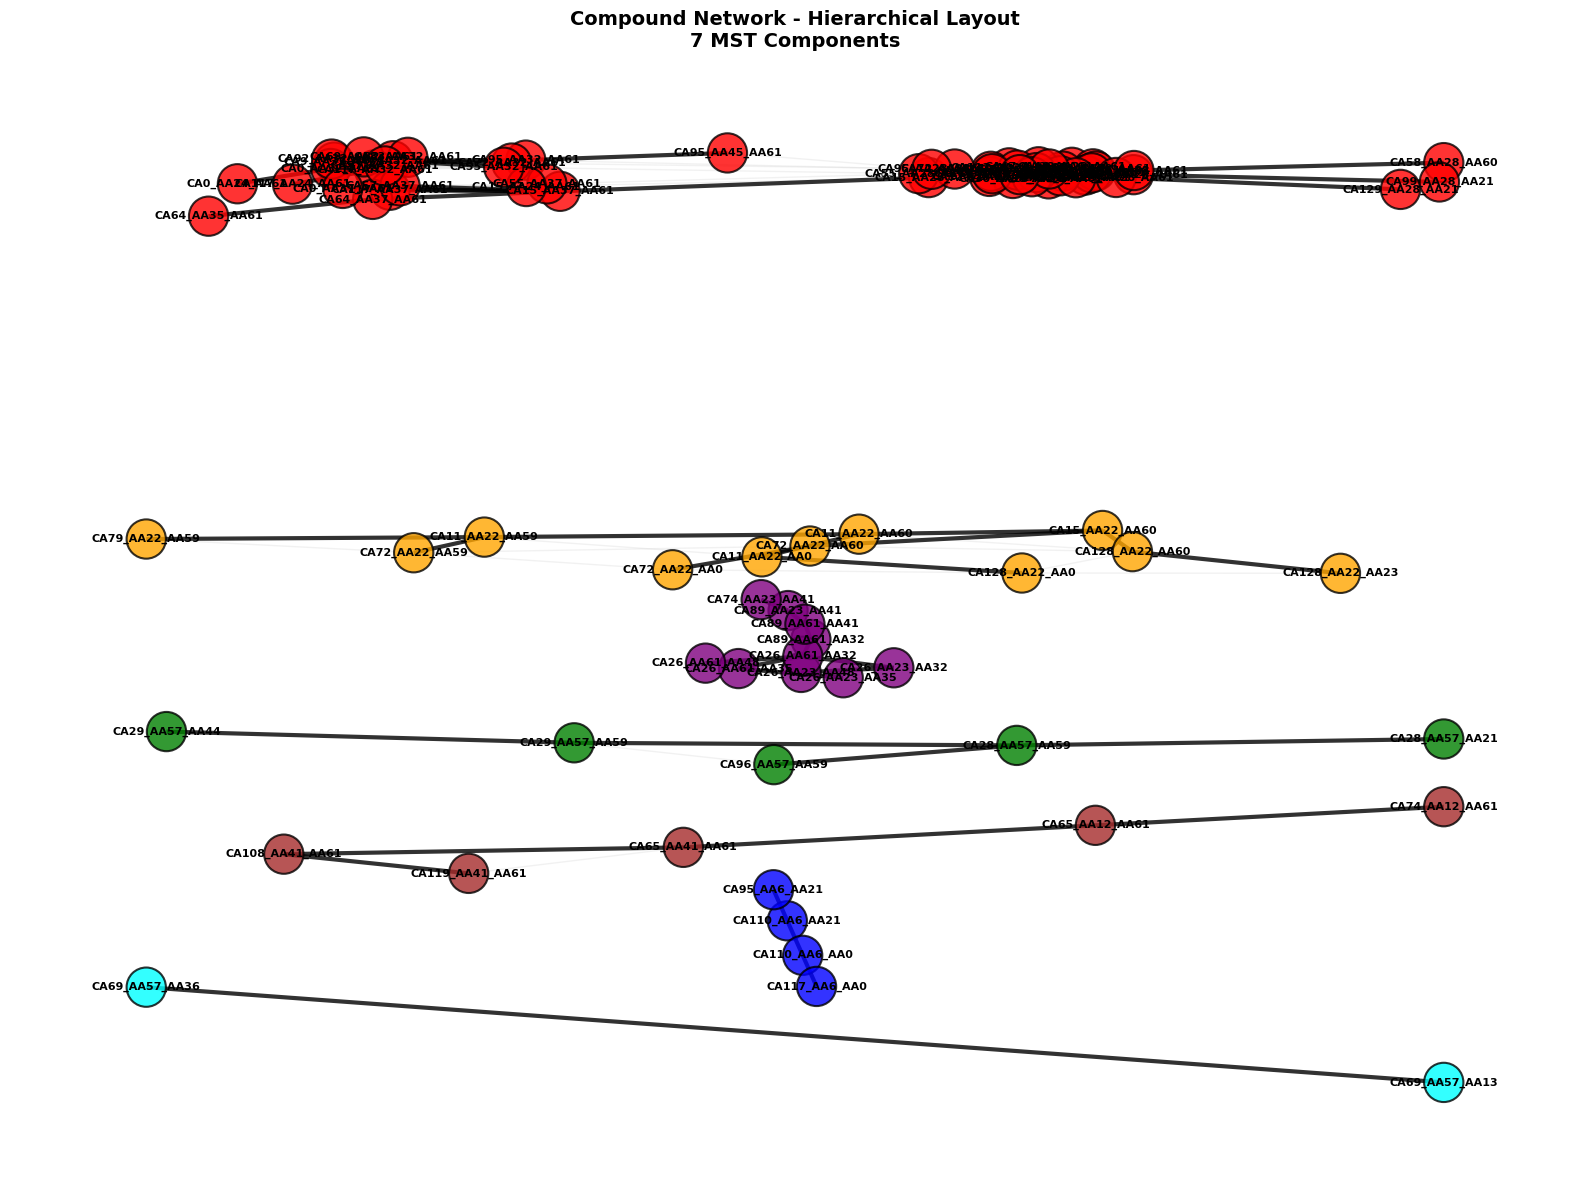


--- CIRCULAR LAYOUT ---


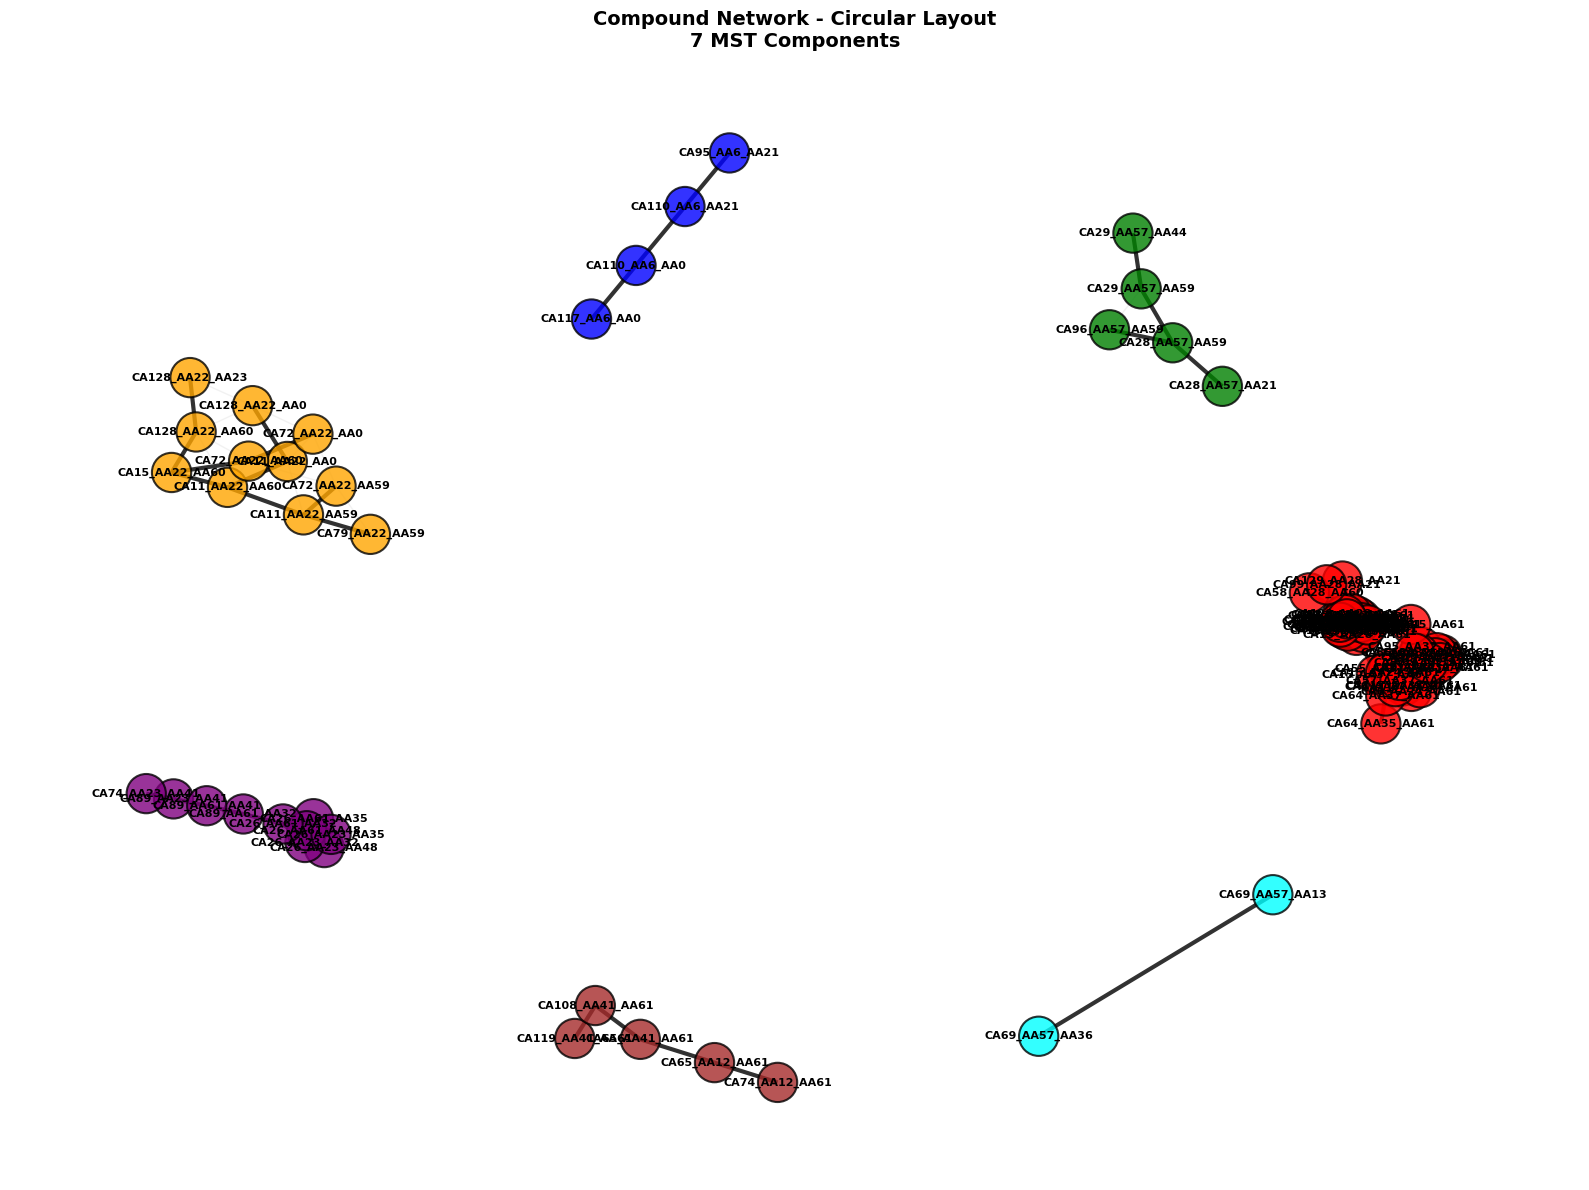


--- GRID LAYOUT ---


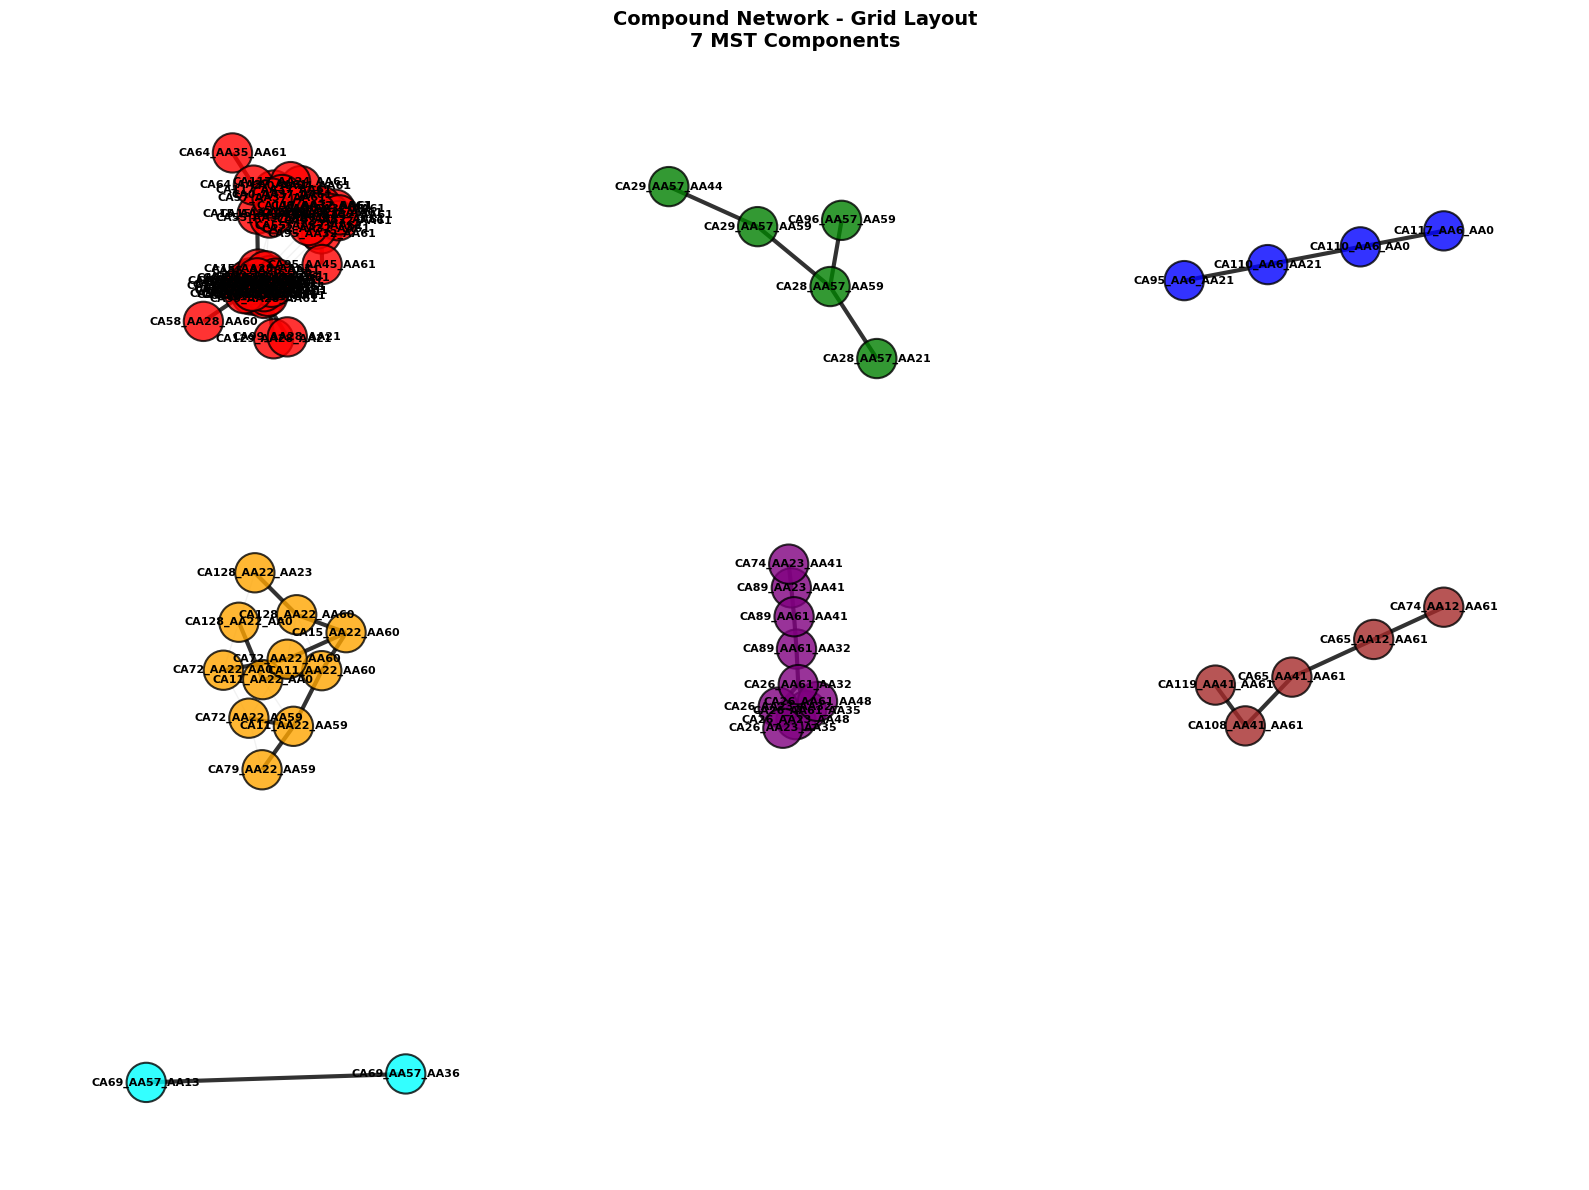


--- GRAPHVIZ LAYOUT ---
Graphviz not available, falling back to spring layout


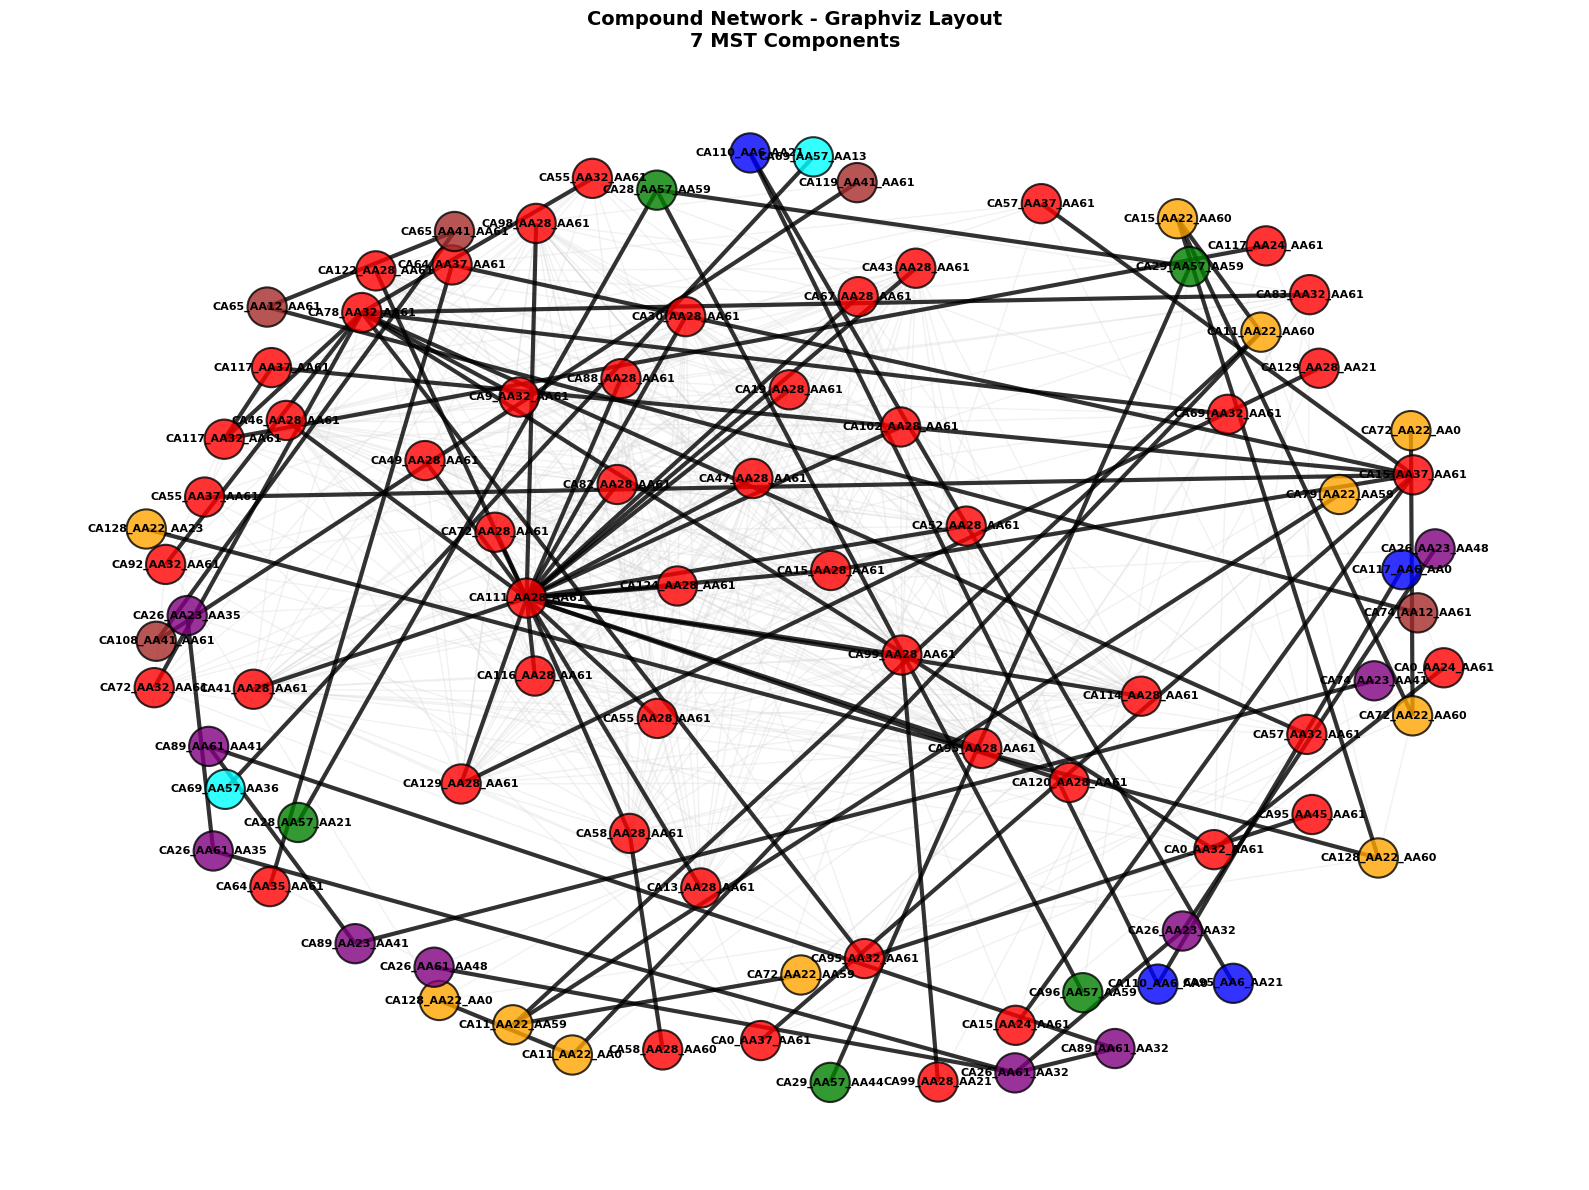

In [55]:
layouts = ['hierarchical', 'circular', 'grid', 'graphviz']

for layout in layouts:
    print(f"\n--- {layout.upper()} LAYOUT ---")
    visualize_compound_network_with_layouts(G, layout_type=layout)

In [57]:
# Example 2: Custom layout for specific use case
def create_custom_compound_layout(G, components):
    """
    Custom layout optimized for compound analysis
    """
    pos = {}
    
    # Separate large and small components
    large_components = [c for c in components if len(c) >= 10]
    small_components = [c for c in components if len(c) < 10]
    
    # Place large components in center area
    if large_components:
        for i, component in enumerate(large_components):
            center = (i * 8, 0)  # Horizontal arrangement
            subgraph = G.subgraph(component)
            component_pos = nx.spring_layout(subgraph, center=center, scale=2)
            pos.update(component_pos)
    
    # Place small components around the periphery
    import math
    radius = 12
    angle_step = 2 * math.pi / max(len(small_components), 1)
    
    for i, component in enumerate(small_components):
        center_x = radius * math.cos(i * angle_step)
        center_y = radius * math.sin(i * angle_step)
        center = (center_x, center_y)
        
        subgraph = G.subgraph(component)
        if len(component) == 1:
            # Single node - place at center
            pos.update({list(component)[0]: center})
        else:
            component_pos = nx.spring_layout(subgraph, center=center, scale=0.5)
            pos.update(component_pos)
    
    return pos

# Example 3: Using the custom layout
def visualize_with_custom_layout(G):
    components = list(nx.connected_components(G))
    pos = create_custom_compound_layout(G, components)
    
    plt.figure(figsize=(16, 12))
    
    # Color nodes by component
    mst_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
    node_colors = []
    for node in G.nodes():
        for i, component in enumerate(components):
            if node in component:
                node_colors.append(mst_colors[i % len(mst_colors)])
                break
    
    nx.draw(G, pos, node_color=node_colors, node_size=800, 
            with_labels=True, font_size=8, alpha=0.8)
    
    plt.title("Custom Compound Layout\nLarge clusters centered, small clusters on periphery")
    plt.show()



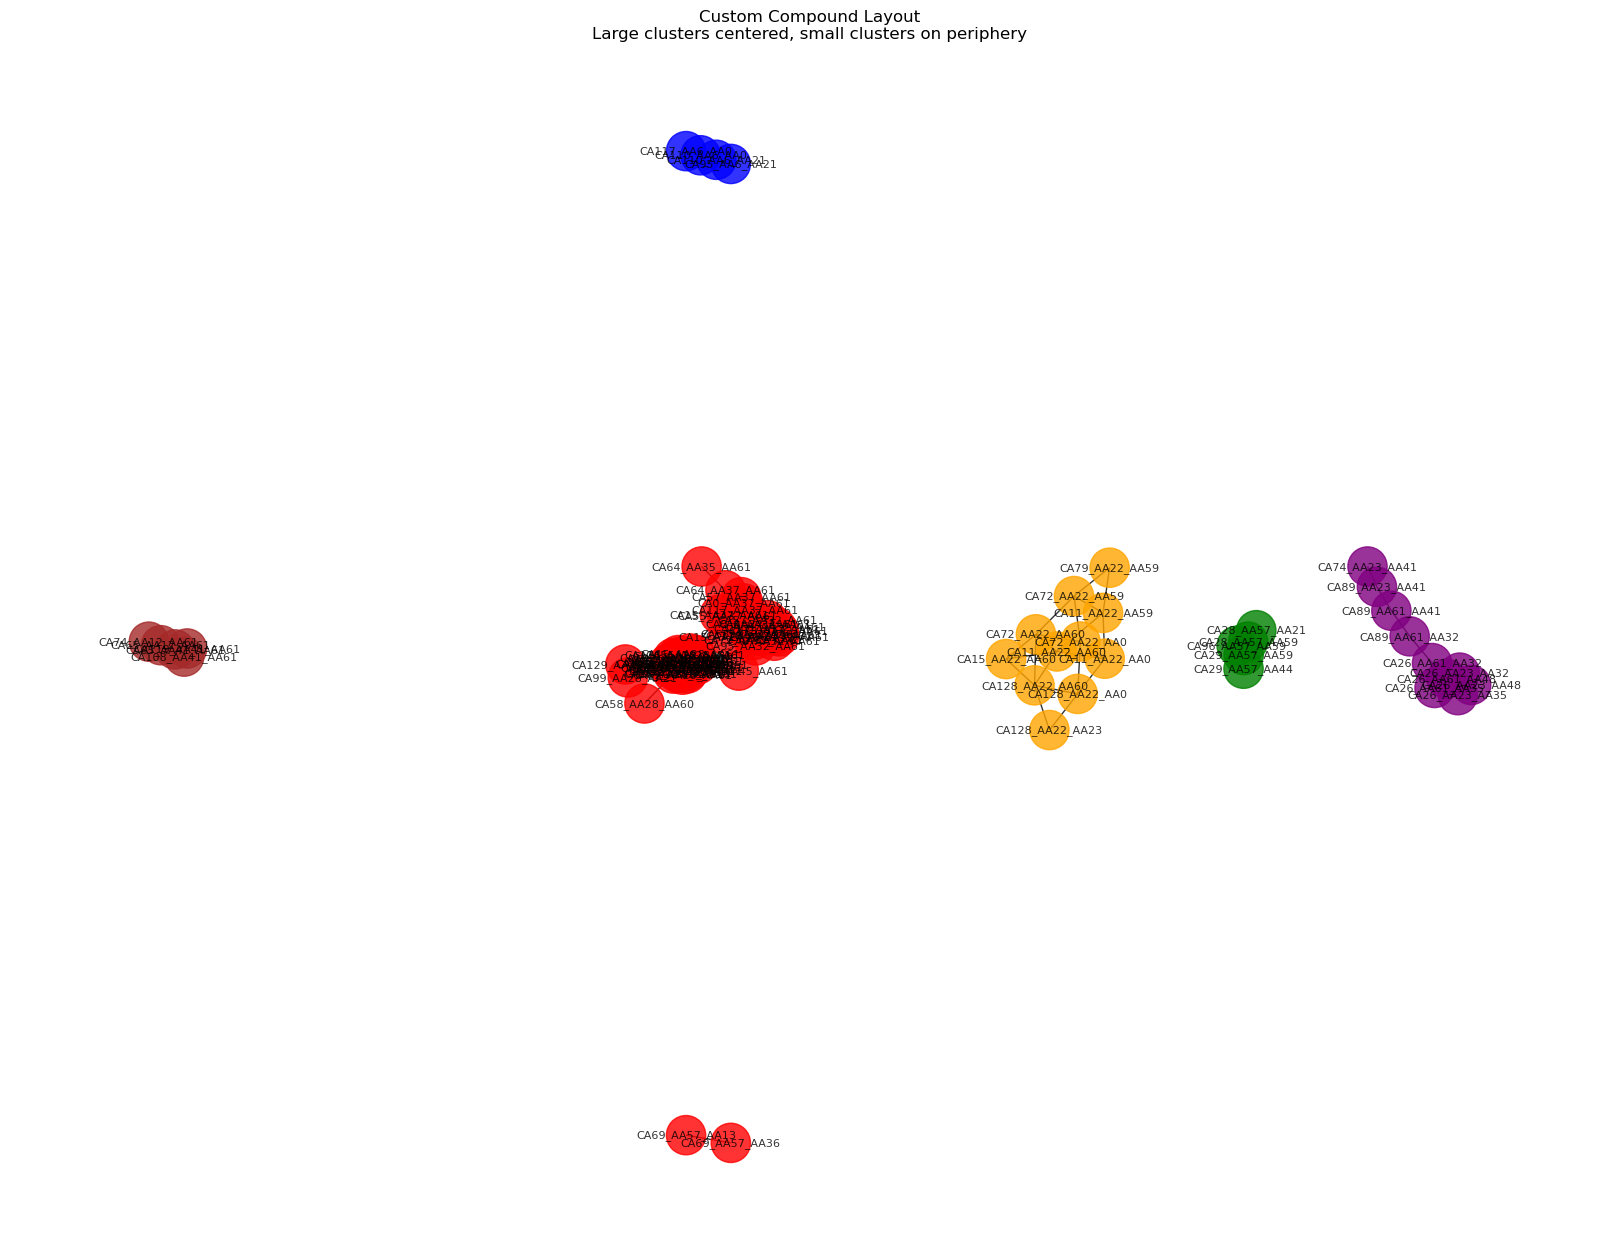

In [58]:
visualize_with_custom_layout(G)

✓ Minimum spanning trees exist for 7 connected components.
  Component 1: 52 nodes, MST has 51 edges
  Component 2: 5 nodes, MST has 4 edges
  Component 3: 4 nodes, MST has 3 edges
  Component 4: 11 nodes, MST has 10 edges
  Component 5: 10 nodes, MST has 9 edges
  Component 6: 5 nodes, MST has 4 edges
  Component 7: 2 nodes, MST has 1 edges


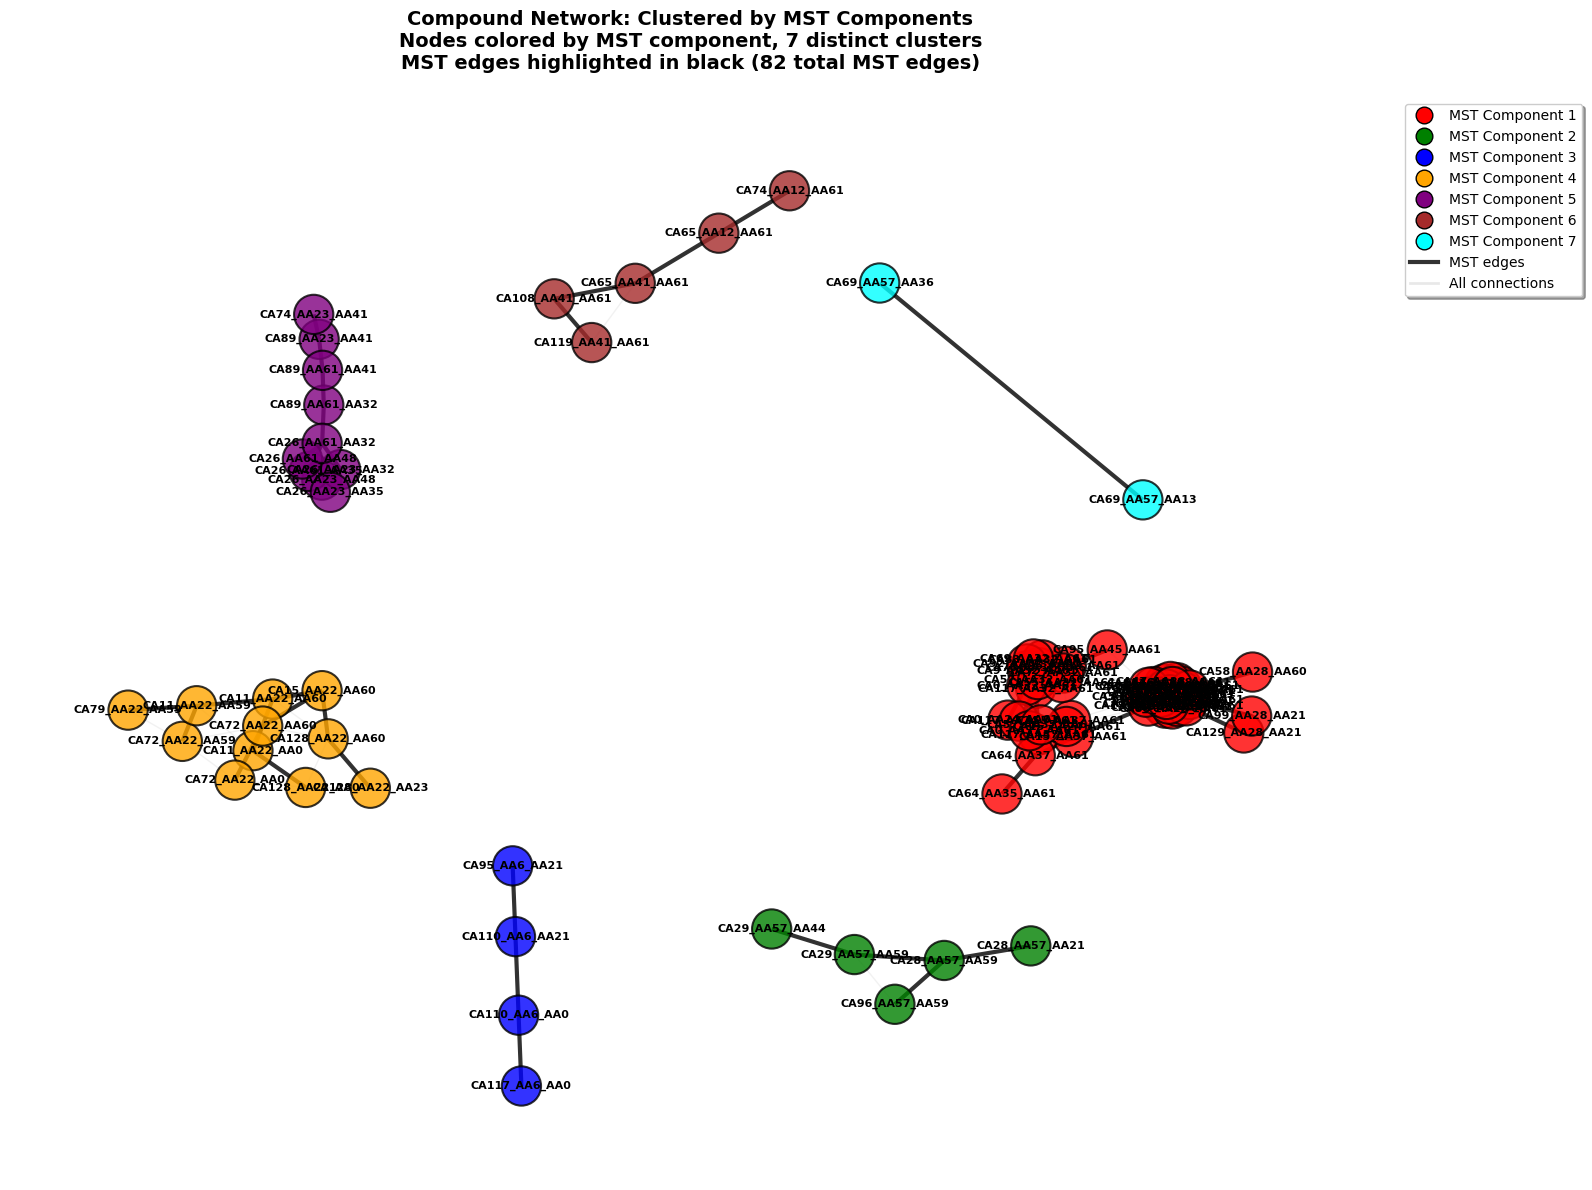

In [53]:
visualize_compound_network(G)

In [12]:
import networkx as nx
import pandas as pd
from collections import Counter

def extract_and_analyze_clusters(G):
    """
    Extract clusters and analyze building block distribution
    """
    # Extract clusters of nodes
    clusters = list(nx.connected_components(G))
    clusters_list = [list(cluster) for cluster in clusters]
    
    # Analyze building blocks per cluster
    cluster_stats = []
    
    for i, cluster in enumerate(clusters_list):
        # Extract building blocks from node names
        building_blocks = []
        for compound in cluster:
            blocks = compound.split('_')
            building_blocks.extend(blocks)
        
        # Count unique building blocks
        block_counts = Counter(building_blocks)
        
        # Count how many compounds contain each building block
        compound_counts = {}
        for block in block_counts.keys():
            compound_counts[block] = sum(block in compound.split('_') for compound in cluster)
        
        cluster_stats.append({
            'cluster_id': i+1,
            'compounds': cluster,
            'num_compounds': len(cluster),
            'num_unique_building_blocks': len(block_counts),
            'building_block_counts': block_counts,
            'compound_counts': compound_counts
        })
    
    return clusters_list, cluster_stats

def print_clusters_as_lists(clusters_list):
    """
    Print clusters in copy-pasteable Python list format
    """
    print("Cluster Node Names (Copy-Pasteable Format):")
    print("=" * 50)
    
    for i, cluster in enumerate(clusters_list, 1):
        # Sort cluster for consistent output
        sorted_cluster = sorted(cluster)
        
        # Format as Python list
        cluster_str = str(sorted_cluster)
        
        print(f"# Cluster {i} ({len(cluster)} compounds)")
        print(f"cluster_{i} = {cluster_str}")
        print()

def print_all_clusters_combined(clusters_list):
    """
    Print all clusters as a single nested list structure
    """
    print("All Clusters Combined (Copy-Pasteable Format):")
    print("=" * 50)
    
    # Sort each cluster and create nested structure
    all_clusters = [sorted(cluster) for cluster in clusters_list]
    
    print("all_clusters = [")
    for i, cluster in enumerate(all_clusters):
        cluster_str = str(cluster)
        if i < len(all_clusters) - 1:
            print(f"    {cluster_str},  # Cluster {i+1}")
        else:
            print(f"    {cluster_str}   # Cluster {i+1}")
    print("]")
    print()

def print_individual_variables(clusters_list):
    """
    Print each cluster as a separate variable assignment
    """
    print("Individual Cluster Variables (Copy-Pasteable Format):")
    print("=" * 50)
    
    for i, cluster in enumerate(clusters_list, 1):
        sorted_cluster = sorted(cluster)
        print(f"cluster_{i} = {sorted_cluster}")
    
    print()
    print("# To access all clusters:")
    cluster_vars = [f"cluster_{i}" for i in range(1, len(clusters_list) + 1)]
    print(f"all_clusters = [{', '.join(cluster_vars)}]")
    print()

In [13]:
# Extract clusters and analyze
clusters_list, cluster_stats = extract_and_analyze_clusters(G)

# Print in different copy-pasteable formats
print_clusters_as_lists(clusters_list)
print_all_clusters_combined(clusters_list)
print_individual_variables(clusters_list)

# Continue with building block analysis
summary_table = create_building_block_summary_table(cluster_stats)
print("Building Block Distribution Table:")
print(summary_table)



Cluster Node Names (Copy-Pasteable Format):
# Cluster 1 (52 compounds)
cluster_1 = ['CA0_AA24_AA61', 'CA0_AA32_AA61', 'CA0_AA37_AA61', 'CA102_AA28_AA61', 'CA111_AA28_AA61', 'CA114_AA28_AA61', 'CA116_AA28_AA61', 'CA117_AA24_AA61', 'CA117_AA32_AA61', 'CA117_AA37_AA61', 'CA120_AA28_AA61', 'CA122_AA28_AA61', 'CA124_AA28_AA61', 'CA129_AA28_AA21', 'CA129_AA28_AA61', 'CA13_AA28_AA61', 'CA15_AA24_AA61', 'CA15_AA28_AA61', 'CA15_AA37_AA61', 'CA19_AA28_AA61', 'CA30_AA28_AA61', 'CA41_AA28_AA61', 'CA43_AA28_AA61', 'CA46_AA28_AA61', 'CA47_AA28_AA61', 'CA49_AA28_AA61', 'CA52_AA28_AA61', 'CA55_AA28_AA61', 'CA55_AA32_AA61', 'CA55_AA37_AA61', 'CA57_AA32_AA61', 'CA57_AA37_AA61', 'CA58_AA28_AA60', 'CA58_AA28_AA61', 'CA64_AA35_AA61', 'CA64_AA37_AA61', 'CA67_AA28_AA61', 'CA69_AA32_AA61', 'CA72_AA28_AA61', 'CA72_AA32_AA61', 'CA78_AA32_AA61', 'CA82_AA28_AA61', 'CA83_AA32_AA61', 'CA88_AA28_AA61', 'CA92_AA32_AA61', 'CA95_AA28_AA61', 'CA95_AA32_AA61', 'CA95_AA45_AA61', 'CA98_AA28_AA61', 'CA99_AA28_AA21', 'CA99_A

NameError: name 'create_building_block_summary_table' is not defined